# Create train, test and validation dataframes

### No normalization

### Augmentation added


In [2]:
import datetime
#from pathlib import Path
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import os.path
import numpy as np

# Input File Selection and Directory Setup

In [3]:
# Input file can be varied to point to different files.
# However, this model assumes these columns:
#  Z (Target) 
#  X (Feature 1 or X_1)
#  Y (Feature 1 or X_2)
#  ... (Feature N)
#
# For this demo, it was three columns where:
#    where z = x + y

# sample data for easy x+y=z
# JUST z=10
#CSV_FILE_NAME = "xyz10.csv"

# sample data for easy x+y=z
CSV_FILE_NAME = "xyz.csv"

os.environ['CSV_FILE_NAME'] = CSV_FILE_NAME

In [4]:
# The current directory will be where this src file is located.
# Which is in the src dir of the project
dirpath = os.getcwd()
print("current directory is : " + dirpath)

current directory is : /Users/davis/progs/github/Keras-Philosophy/notebooks


In [5]:
# Use pathlib to find the root dir of the git repo
root_path = pathlib.PurePath(dirpath).parents[0]
data_path = root_path / 'data'
logs_path = root_path / 'logs'
print("root directory is: ", root_path)
print("data directory is: ",  data_path)
print("logs directory is: ", logs_path)

root directory is:  /Users/davis/progs/github/Keras-Philosophy
data directory is:  /Users/davis/progs/github/Keras-Philosophy/data
logs directory is:  /Users/davis/progs/github/Keras-Philosophy/logs


In [6]:
# Create equivalent dir names in the environment
# Logs
LOGS_DIR_NAME = logs_path.as_posix()
print("LOGS_DIR_NAME: ", LOGS_DIR_NAME)
os.environ['LOGS_DIR_NAME'] = LOGS_DIR_NAME
# Data
DATA_DIR_NAME = data_path.as_posix()
print("DATA_DIR_NAME: ", DATA_DIR_NAME)
os.environ['DATA_DIR_NAME'] = DATA_DIR_NAME

LOGS_DIR_NAME:  /Users/davis/progs/github/Keras-Philosophy/logs
DATA_DIR_NAME:  /Users/davis/progs/github/Keras-Philosophy/data


In [9]:
%%bash
head -n 5 "${DATA_DIR_NAME}/${CSV_FILE_NAME}"

z,x,y
10.0,10.0,0.0
10.0,9.0,1.0
10.0,8.0,2.0
10.0,7.0,3.0


# Use pandas to read csv into dataframe

In [10]:
raw_dataframe = pd.read_csv(data_path / CSV_FILE_NAME, 
                          header=0,
                          sep=",")

dataframe = raw_dataframe.copy()

In [11]:
dataframe.shape
dataframe.head()

,z,x,y
0,10.0,10.0,0.0
1,10.0,9.0,1.0
2,10.0,8.0,2.0
3,10.0,7.0,3.0
4,10.0,6.0,4.0


# plot the data

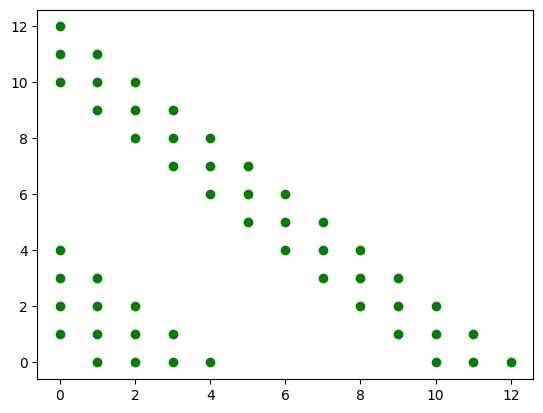

In [20]:
plt.scatter(dataframe['y'], dataframe['x'], c='green')

# Augment the data

Increase the size of the existing dataset by creating a new copy.  In the copy add tiny amount to x column and then subtract the same amount to the y column so that the sum remains constant.  Dupe this process 100 times.

In [26]:
# create a routine to augment an existing df
def create_aug_df(a_df): 

    copy_df = a_df.copy()

    # drop rows with zero in X
    copy_df = copy_df[copy_df.x != 0]

    # drop rows with zero in y
    copy_df = copy_df[copy_df.y != 0]

    # so we don't introduce negative numbers, get the minimum and set that 
    # as the floor. 
    min_val = copy_df.min(axis=None)
    rnd_val = np.random.rand()
    mod_val = np.minimum(min_val, rnd_val)
    #print("min_value: ",min_val)
    #print("mod_value: ", mod_val)

    # adj columns x and y by mod amount
    copy_df['x'] = copy_df['x'] + mod_val
    copy_df['y'] = copy_df['y'] - mod_val

    return copy_df


In [27]:
# use the function to create a larger augmented dataframe
df_list = []
for x in range(0,10):
    df_list.append(create_aug_df(dataframe))

aug_df = pd.concat(df_list)
#print("augmented df shape: ", aug_df.shape)
#print("aug_df head: ")
#print(aug_df.head())

# plot the data

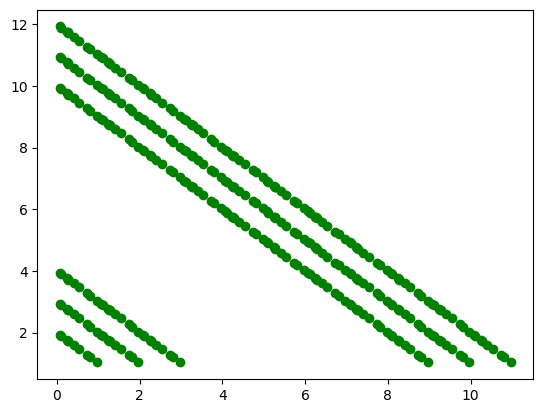

In [28]:
plt.scatter(aug_df['y'], aug_df['x'], c='green')

# Create Train, Test and Validation DataFrames

In [29]:
# Since we used concat, our index is screwed uup
# create a new index and apply it
num_rows = aug_df.shape[0]
index = pd.Index(range(0,num_rows))
aug_df.set_index(index,inplace=True)


In [30]:



# sample 70% of aumented data to the train_df
train_df = aug_df.sample(frac=0.7,random_state=3367)

# what's leftover will be split into test and train evenly
leftover_df = aug_df.drop(train_df.index) 

# split what's leftover into test and validation                       
test_df = leftover_df.sample(frac=0.5, random_state=3367)
valid_df = leftover_df.drop(test_df.index)

# print sizes as check
print("train shape: ", train_df.shape)
print("test shape: ", test_df.shape)
print("valid shape: ", valid_df.shape)



train shape:  (252, 3)
test shape:  (54, 3)
valid shape:  (54, 3)


# write the dataframes to disk

In [31]:
train_df.to_csv(data_path /  pathlib.PurePath("train.csv"), encoding='utf-8', index=False)
valid_df.to_csv(data_path /  pathlib.PurePath("valid.csv"), encoding='utf-8', index=False)
test_df.to_csv(data_path /  pathlib.PurePath("test.csv"), encoding="utf-8", index=False)


In [32]:
# typically only use the train dataframe to normalize the data
train_stats_df = train_df
train_stats = train_stats_df.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
z,252.0,9.809524,2.977242,2.000000,10.000000,11.000000,12.000000,12.000000
x,252.0,5.391256,3.080242,1.027956,2.687230,4.823760,8.068989,11.889421
y,252.0,4.418268,3.122868,0.074200,1.407788,4.023122,7.241901,10.972044


In [33]:
train_df

,z,x,y
262,11.0,9.925800,1.074200
4,10.0,5.192089,4.807911
207,12.0,3.592212,8.407788
326,10.0,7.267390,2.732610
161,11.0,2.758099,8.241901
...,...,...,...
286,4.0,2.925800,1.074200
201,12.0,9.592212,2.407788
160,11.0,3.758099,7.241901
282,2.0,1.925800,0.074200


# Plot the dataframes

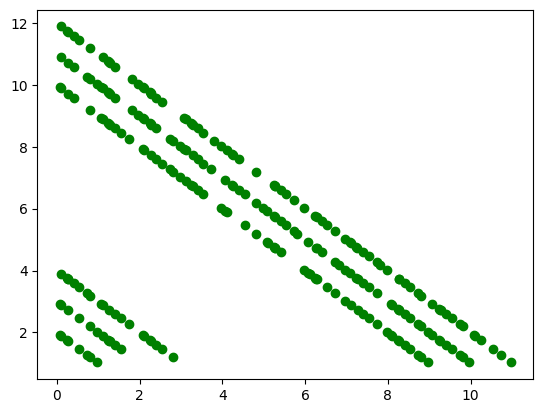

In [34]:
plt.scatter(train_df['y'], train_df['x'], c='green')

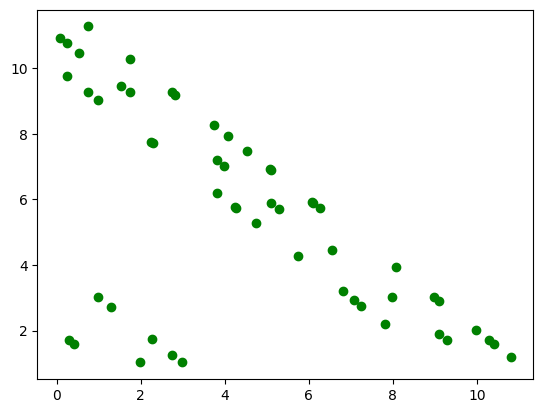

In [35]:
plt.scatter(valid_df['y'], valid_df['x'], c='green')

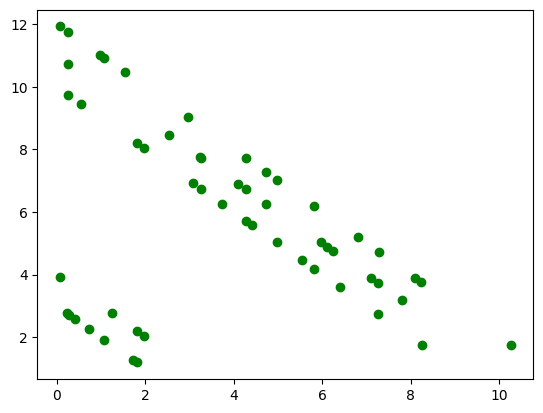

In [36]:
plt.scatter(test_df['y'], test_df['x'], c='green')